# RL and Advanced DL: Домашнее задание 2

In [1]:
import gym
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [2]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows, n_cols, n_win):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def _check_terminal(self, cur_p):
        cur_marks = np.where(self.board == cur_p)
        for i,j in zip(cur_marks[0], cur_marks[1]):
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    return True
            if j <= self.n_cols - self.n_win:
                if np.all(self.board[i,j:j+self.n_win] == cur_p):
                    return True
            if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                    return True
            if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                    return True
        return False
    
    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_win = self._check_terminal(self.curTurn)
        if cur_win:
                self.gameOver = True
                return self.curTurn
            
        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def getWinner(self):
        # фактически запускаем isTerminal два раза для крестиков и ноликов
        if self._check_terminal(1):
            return 1
        if self._check_terminal(-1):
            return -1
        if len(self.getEmptySpaces()) == 0:
            return 0
        return None
    
    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

# Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

* Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

* Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

> Disclaimer: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

In [3]:
class BaseAgent:
    """Базовый агент."""
    def __init__(self, env, gamma, alpha):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.action_size = env.n_rows * env.n_cols
        self.a2n = self._action_to_number(env.n_rows, env.n_cols)
        self.n2a = self._number_to_action(env.n_rows, env.n_cols)
        
    def get_action(self, state, eps=0.0):
        pass
    
    def updateQ(self, state, action, new_state, reward, val=False):
        pass
    
    def _number_to_action(self, n_rows, n_cols):     
        n2a = {i * n_cols + j: (i, j) for i in range(n_rows) for j in range(n_cols)}
        return n2a
    
    def _action_to_number(self, n_rows, n_cols):     
        a2n = {(i, j): i * n_cols + j for i in range(n_rows) for j in range(n_cols)}
        return a2n

    
class RandomAgent(BaseAgent):
    """Случайный агент."""
    def __init__(self, env, gamma, alpha):
        super().__init__(env, gamma, alpha)
    
    def get_action(self, state, eps=0.0):
        """Действие."""
        possible_actions = self.env.getState()[1]
        _possible_actions = [self.a2n[tuple(act)] for act in possible_actions]
        action = np.random.choice(_possible_actions)
        return action


class Agent(BaseAgent):
    """Обучаемый агент."""
    def __init__(self, env, gamma, alpha):
        super().__init__(env, gamma, alpha)
        self.Q = {}
        
    def updateQ(self, state, action, new_state, reward, val=False):
        """Обновление матрицы Q.""" 
        if val:
            return None
        if new_state not in self.Q:
            self.Q[new_state] = np.zeros(self.action_size)
        Q = self.Q[state][action]
        Qmax = max(self.Q[new_state])
        self.Q[state][action] += self.alpha * (reward + self.gamma * Qmax - Q)
        
    def get_action(self, state, eps=0.0):
        """Действие."""
        if state not in self.Q:
            self.Q[state] = np.zeros(self.action_size)
        possible_actions = self.env.getState()[1]
        _possible_actions = [self.a2n[tuple(act)] for act in possible_actions]
        if np.random.random() > eps:
            action = _possible_actions[np.argmax(self.Q[state][_possible_actions])]
        else:
            action = np.random.choice(_possible_actions)
        return action
    

In [4]:
class Qlearning:
    
    def __init__(self, env, eps_min=0.1, gamma=1., alpha=1e-3):
        """Инициализация."""
        self.env = env
        self.eps_min = eps_min
        self.agent_cross = Agent(env=env, gamma=gamma, alpha=alpha)  # крестики
        self.agent_nought = Agent(env=env, gamma=gamma, alpha=alpha)  # нолики
        self.agent_rand = RandomAgent(env=env, gamma=gamma, alpha=alpha)
        
    def step(self, agent1, agent2, eps, val=False, show=False):
        """Одна игра."""
        
        self.env.reset()
        terminated = False

        state1_prev = self.env.getState()[0]
        action1 = agent1.get_action(state1_prev, eps)
        (state2_prev, _, _), reward, terminated, _ = self.env.step(agent1.n2a[action1])
        
        while not terminated:
            
            action2 = agent2.get_action(state2_prev, eps)
            (state2_cur, _, _), reward, terminated, _ = self.env.step(agent2.n2a[action2])
            agent1.updateQ(state=state1_prev, action=action1, new_state=state2_cur, reward=reward, val=val)
            if terminated:
                agent2.updateQ(state=state2_prev, action=action2, new_state=state2_cur, reward=-reward, val=val)
                break
                
            state1_prev = state2_cur
            
            action1 = agent1.get_action(state1_prev, eps)
            (state1_cur, _, _), reward, terminated, _ = self.env.step(agent1.n2a[action1])
            agent2.updateQ(state=state2_prev, action=action2, new_state=state1_cur, reward=-reward, val=val)
            if terminated:
                agent1.updateQ(state=state1_prev, action=action1, new_state=state1_cur, reward=reward, val=val)
                break
                
            state2_prev = state1_cur
            
        if show:
            self.env.printBoard()
            
        return reward
        
    def train(self, train_games=1001, val_games=1000, val_step=1000, eps=0.1, eps_decay=1., eps_decay_step=100):
        """Обучение."""
        
        mean_reward_cross, mean_reward_nought, win_rate_cross, win_rate_nought, episode = [], [], [], [], []

        pbar = tqdm(range(train_games))
        
        for i in pbar:
            
            if (i + 1) % eps_decay_step == 0:
                eps *= eps_decay
                if eps < self.eps_min:
                    eps = self.eps_min
                    
            if (i % val_step == 0):
                r_cross, _, w_cross, _ = self.validate(agent1=self.agent_cross, agent2=self.agent_rand, n_games=val_games)
                _, r_nought, _, w_nought = self.validate(agent1=self.agent_rand, agent2=self.agent_nought, n_games=val_games)
                episode.append(i)
                mean_reward_cross.append(r_cross)
                mean_reward_nought.append(r_nought)
                win_rate_cross.append(w_cross)
                win_rate_nought.append(w_nought)
                
            self.step(agent1=self.agent_cross, agent2=self.agent_nought, eps=eps)
            
            pbar.set_description("%f, %f, %f" % (r_cross, r_nought, eps))
            
        return episode, mean_reward_cross, mean_reward_nought, win_rate_cross, win_rate_nought
    
    def validate(self, agent1, agent2, n_games):
        """Валидация текущей стратегии."""
        # n_games - количество игр, на которых проверяем
        mean_reward_agent1 = 0
        mean_reward_agent2 = 0
        win_rate_agent1 = 0
        win_rate_agent2 = 0
        for i in range(n_games):
            reward = self.step(agent1=agent1, agent2=agent2, eps=0.0, val=True)
            mean_reward_agent1 = (mean_reward_agent1 * i + reward) / (i + 1)
            mean_reward_agent2 = (mean_reward_agent2 * i - reward) / (i + 1)
            if reward == 1:
                win_rate_agent1 += 1
            elif reward == -1:
                win_rate_agent2 += 1
                
        return (
            mean_reward_agent1, 
            mean_reward_agent2, 
            win_rate_agent1 / n_games, 
            win_rate_agent2 / n_games
        )
    
    def plot_result(self, episode, metric_cross, metric_nought, title=""):
        """Построение графиков."""
        plt.figure(figsize=(10, 5))
        plt.plot(episode, metric_cross, label="cross (x)")
        plt.plot(episode, metric_nought, label="nought (o)")
        plt.title(title, fontsize=10)
        plt.xlabel("Number of episodes", fontsize=10)
        plt.grid(which="major", linestyle="--")
        plt.tick_params(axis="both", which="major", labelsize=10)
        plt.legend(fontsize=12);
        

## a) Доска 3х3, Q-learning

In [62]:
np.random.seed(123)

N_ROWS = 3
N_COLS = 3
N_WIN = 3
ALPHA = 1e-2
GAMMA = 1.0
EPS_MIN = 0.05

In [63]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
ql3 = Qlearning(env, eps_min=EPS_MIN, gamma=GAMMA, alpha=ALPHA)

episode, mean_reward_cross, mean_reward_nought, win_rate_cross, win_rate_nought = ql3.train(
    train_games=100_001,  # сколько игр учимся 
    val_games=1_000,  # количество игр, на котором валидируемся 
    val_step=5_000,  # как часто валидируемся
    eps=0.95,  # начальный eps
    eps_decay=0.95,  # коэффициент понижения eps
    eps_decay_step=1_000  # как часто уменьшаем eps
)

0.981000, 0.870000, 0.050000: 100%|████| 100001/100001 [02:20<00:00, 712.47it/s]


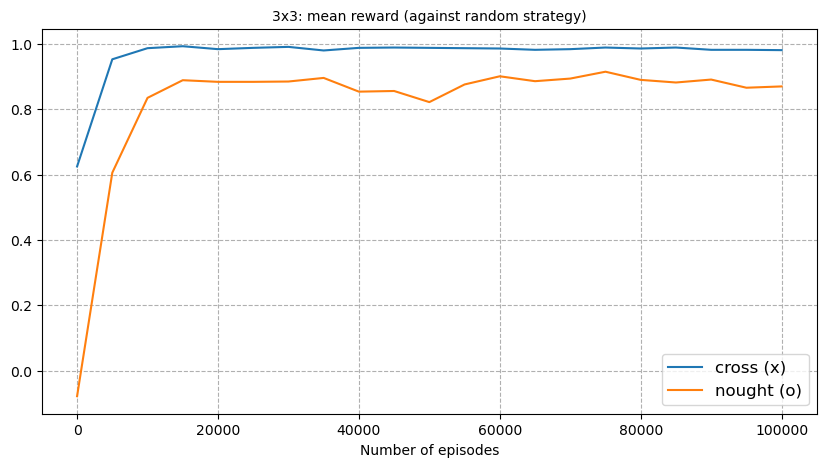

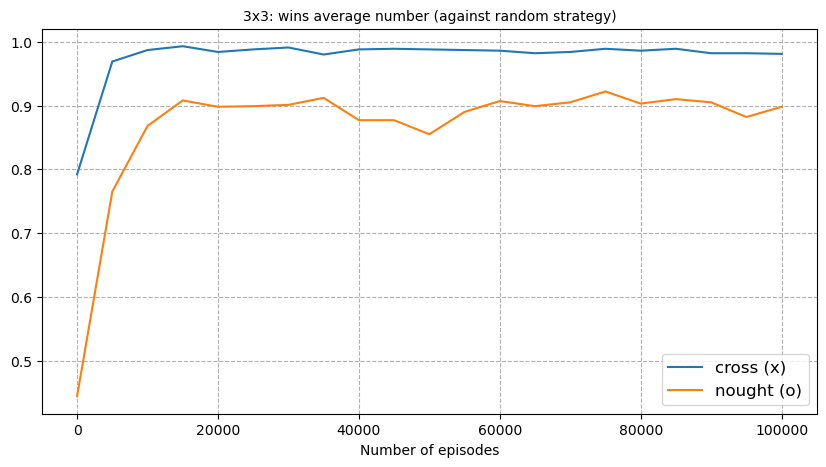

In [64]:
ql3.plot_result(
    episode, mean_reward_cross, mean_reward_nought, 
    title=f"{env.n_rows}x{env.n_cols}: mean reward (against random strategy)"
)
ql3.plot_result(
    episode, win_rate_cross, win_rate_nought, 
    title=f"{env.n_rows}x{env.n_cols}: wins average number (against random strategy)"
)

## b) Доска 4х4, Q-learning

In [25]:
np.random.seed(123)

N_ROWS = 4
N_COLS = 4
N_WIN = 4
ALPHA = 1e-4
GAMMA = 1.0
EPS_MIN = 0.3

In [26]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
ql4 = Qlearning(env, eps_min=EPS_MIN, gamma=GAMMA, alpha=ALPHA)

episode, mean_reward_cross, mean_reward_nought, win_rate_cross, win_rate_nought = ql4.train(
    train_games=1_000_001,  # сколько игр учимся 
    val_games=1_000,  # количество игр, на котором валидируемся 
    val_step=10_000,  # как часто валидируемся
    eps=0.95,  # начальный eps
    eps_decay=0.95,  # коэффициент понижения eps
    eps_decay_step=1_000  # как часто уменьшаем eps
)

0.775000, 0.537000, 0.300000: 100%|██| 1000001/1000001 [35:25<00:00, 470.49it/s]


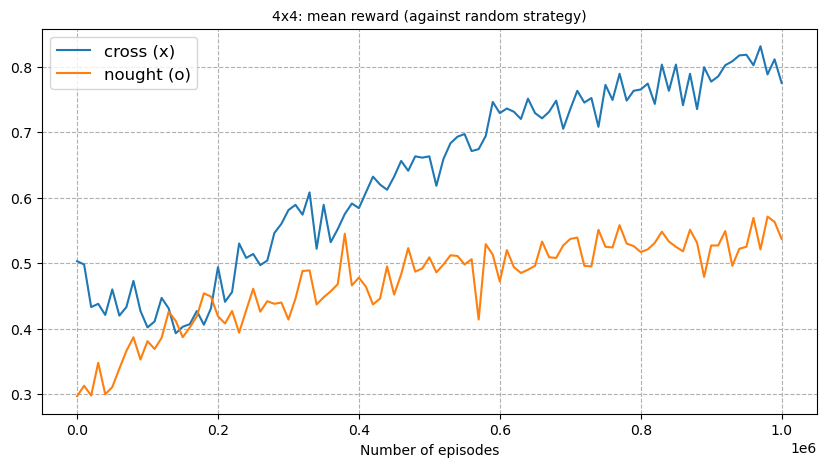

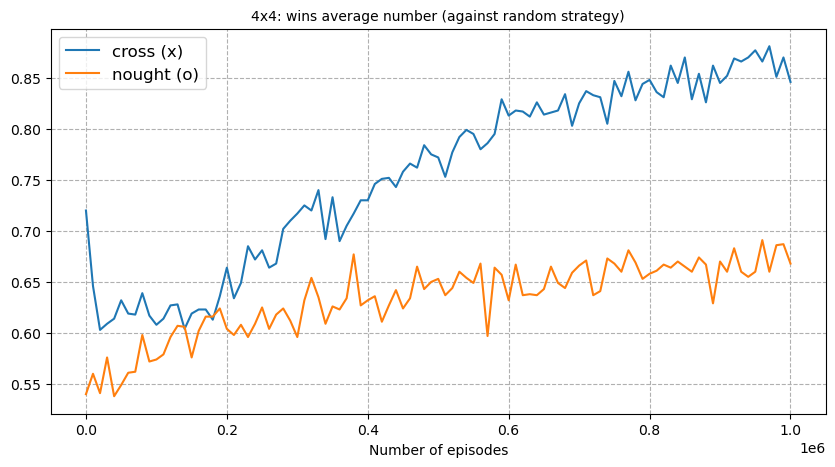

In [27]:
ql4.plot_result(
    episode, mean_reward_cross, mean_reward_nought, 
    title=f"{env.n_rows}x{env.n_cols}: mean reward (against random strategy)"
)
ql4.plot_result(
    episode, win_rate_cross, win_rate_nought, 
    title=f"{env.n_rows}x{env.n_cols}: wins average number (against random strategy)"
)

## Выводы по первой части

* Для доски **3х3** все хорошо получилось. Для крестиков средний выигрыш против случайной стратегии составил порядка $0,98$, для ноликов - порядка $0,89$. Хватило $20.000$ игр для сходимости процесса обучения.

* Для доски **4х4** все существенно медленнее сходится. Обучение было запущено на $1.000.000$ игр. Для крестиков средний выигрыш против случайной стратегии составил порядка $0,8$ (не менее, чем в *85%* играх выигрываем), для ноликов - порядка $0,55$ (не менее, чем в *65%* играх выигрываем). При этом видна динамика роста в конце, что процесс еще не сошелся. 

* Для доски **5х5** не смог посчитать.

# Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).
* Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
* Реализуйте Double DQN и/или Dueling DQN.

In [5]:
class ReplayBuffer:
    def __init__(self, size=10000):
        self.data = deque(maxlen=size)

    def add(self, transition):
        self.data.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.data, k=batch_size)
        batch = list(zip(*batch))
        
        state, action, next_state, reward, terminated = batch
        
        state = torch.tensor(np.array(self._to_tensor(state)), dtype=torch.float32)
        action = torch.tensor(np.array(action)).long()
        next_state = torch.tensor(np.array(self._to_tensor(next_state)), dtype=torch.float32)
        reward = torch.tensor(np.array(reward)).long()
        terminated = torch.tensor(np.array(terminated).astype(np.uint8)).float()
        
        return (state, action, next_state, reward, terminated)
    
    def _to_tensor(self, state):
        return [
            np.array(
                list(map(int, st))
            ).reshape(1, int(np.sqrt(len(st))), int(np.sqrt(len(st)))).tolist()
            for st in state
        ]


In [48]:
class QNetwork3(nn.Module):

    def __init__(self, hidden_size, action_size, seed=0):
        super(QNetwork3, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=hidden_size, kernel_size=3)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = self.conv1(state)
        x = F.relu(x)
        x = self.fc1(x.squeeze(-1).squeeze(-1))
        x = F.relu(x)
        return self.fc2(x)
    
    
class QNetwork4(nn.Module):

    def __init__(self, hidden_size, action_size, seed=0):
        super(QNetwork4, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=hidden_size, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=hidden_size, out_channels=2*hidden_size, kernel_size=2)
        self.fc1 = nn.Linear(2*hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = self.conv1(state)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.fc1(x.squeeze(-1).squeeze(-1))
        x = F.relu(x)
        return self.fc2(x)
    
    
class DuelingQNetwork3(nn.Module):

    def __init__(self, hidden_size, action_size, seed=0):
        super(DuelingQNetwork3, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=hidden_size, kernel_size=3)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2_1 = nn.Linear(hidden_size, 1)
        self.fc2_2 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = self.conv1(state)
        x = F.relu(x)
        x = self.fc1(x.squeeze(-1).squeeze(-1))
        x = F.relu(x)
        v = self.fc2_1(x)
        a = self.fc2_2(x)
        return v + (a - a.mean())  
    
    
class DuelingQNetwork4(nn.Module):

    def __init__(self, hidden_size, action_size, seed=0):
        super(DuelingQNetwork4, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=hidden_size, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=hidden_size, out_channels=2*hidden_size, kernel_size=2)
        self.fc1 = nn.Linear(2*hidden_size, hidden_size)
        self.fc2_1 = nn.Linear(hidden_size, 1)
        self.fc2_2 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = self.conv1(state)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.fc1(x.squeeze(-1).squeeze(-1))
        x = F.relu(x)
        v = self.fc2_1(x)
        a = self.fc2_2(x)
        return v + (a - a.mean())  
    

In [7]:
class DQN:
    def __init__(self, env, qnetwork, hidden_size, action_size):
        self.steps = 0
        self.model = qnetwork(hidden_size=hidden_size, action_size=action_size)
        self.model_target = qnetwork(hidden_size=hidden_size, action_size=action_size)
        self.optimizer = Adam(self.model.parameters(), lr=ALPHA)
        self.memory = ReplayBuffer(size=BUFFER_SIZE)
        
    def consume_transition(self, transition):
        self.memory.add(transition)

    def sample_batch(self):
        return self.memory.sample(batch_size=BATCH_SIZE)

    def train_step(self, batch):
        self.model.train()     
        state, action, next_state, reward, terminated = batch    
        q_target = self.model_target(next_state).detach().max(1)[0].unsqueeze(1)
        q_target = reward.unsqueeze(1) + GAMMA * q_target * (1 - terminated.unsqueeze(1))    
        q_pred = self.model(state).gather(1, action.unsqueeze(1))
        loss = F.mse_loss(q_pred, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def update_target_network(self): 
        self.model_target.load_state_dict(self.model.state_dict())

    def get_action(self, state, eps):
        state = np.array(list(map(int, state)))
        if np.random.random() > eps:
            size_ = int(np.sqrt(state.size))
            state = torch.tensor(state, dtype=torch.float32).reshape(1, size_, size_)
            self.model.eval()
            with torch.no_grad():
                action_values = self.model(state)
            action = np.argmax(action_values.data.numpy())
        else:
            state = np.array(list(map(int, state)))
            action = np.random.choice(np.where(state == 1)[0])
        return action

    def update(self, transition):
        self.consume_transition(transition)
        if self.steps % STEPS_PER_UPDATE == 0:
            batch = self.sample_batch()
            self.train_step(batch)
        if self.steps % STEPS_PER_TARGET_UPDATE == 0:
            self.update_target_network()
        self.steps += 1
        

In [8]:
def buffer_replay_init(env, dqn_cross, dqn_nought):
    
    print("Buffer Replay Init...")

    cross_random_agent = RandomAgent(env, None, None)
    nought_random_agent = RandomAgent(env, None, None)

    for _ in tqdm(range(INITIAL_STEPS)):

        env.reset()
        terminated = False

        state1_prev = env.getState()[0]
        action1 = cross_random_agent.get_action(state1_prev)
        (state2_prev, _, _), reward, terminated, _ = env.step(cross_random_agent.n2a[action1])

        while not terminated:

            action2 = nought_random_agent.get_action(state2_prev)
            (state2_cur, _, _), reward, terminated, _ = env.step(nought_random_agent.n2a[action2])
            dqn_cross.consume_transition([state1_prev, action1, state2_cur, reward, terminated])
            if terminated:
                dqn_nought.consume_transition([state2_prev, action2, state2_cur, -reward, terminated])
                break

            state1_prev = state2_cur

            action1 = cross_random_agent.get_action(state1_prev)
            (state1_cur, _, _), reward, terminated, _ = env.step(cross_random_agent.n2a[action1])
            dqn_nought.consume_transition([state2_prev, action2, state1_cur, -reward, terminated])
            if terminated:
                dqn_cross.consume_transition([state1_prev, action1, state1_cur, reward, terminated])
                break

            state2_prev = state1_cur


In [9]:
def evaluate_policy(env, agent1, agent2, n_games):
    """Валидация текущей стратегии."""
    # n_games - количество игр, на которых проверяем
    mean_reward_agent1 = 0
    mean_reward_agent2 = 0
    win_rate_agent1 = 0
    win_rate_agent2 = 0
    for i in range(n_games):
        reward = step(env=env, agent1=agent1, agent2=agent2, eps=0.0, val=True)
        mean_reward_agent1 = (mean_reward_agent1 * i + reward) / (i + 1)
        mean_reward_agent2 = (mean_reward_agent2 * i - reward) / (i + 1)
        if reward == 1:
            win_rate_agent1 += 1
        elif reward == -1:
            win_rate_agent2 += 1

    return (
        mean_reward_agent1, 
        mean_reward_agent2, 
        win_rate_agent1 / n_games, 
        win_rate_agent2 / n_games
    )


In [10]:
def step(env, agent1, agent2, eps, val=False):
    
    env.reset()
    terminated = False

    state1_prev = env.getState()[0]
    action1 = agent1.get_action(state1_prev, eps)
    (state2_prev, _, _), reward, terminated, _ = env.step(env.action_from_int(action1))

    while not terminated:

        action2 = agent2.get_action(state2_prev, eps)
        (state2_cur, _, _), reward, terminated, _ = env.step(env.action_from_int(action2))
        if not val:
            if reward != -10:
                agent1.update([state1_prev, action1, state2_cur, reward, terminated])
            else:
                agent1.update([state1_prev, action1, state2_cur, -reward, terminated])
        if terminated:
            if not val:
                if reward != -10:
                    agent2.update([state2_prev, action2, state2_cur, -reward, terminated])
                else:
                    agent2.update([state2_prev, action2, state2_cur, reward, terminated])
            break

        state1_prev = state2_cur

        action1 = agent1.get_action(state1_prev, eps)
        (state1_cur, _, _), reward, terminated, _ = env.step(env.action_from_int(action1))
        if not val:
            agent2.update([state2_prev, action2, state1_cur, -reward, terminated])
        if terminated:
            if not val:
                agent1.update([state1_prev, action1, state1_cur, reward, terminated])
            break

        state2_prev = state1_cur
        
    return reward


In [5]:
def plot_result(episode, metric_cross, metric_nought, title=""):
    """Построение графиков."""
    plt.figure(figsize=(10, 5))
    plt.plot(episode, metric_cross, label="cross (x)")
    plt.plot(episode, metric_nought, label="nought (o)")
    plt.title(title, fontsize=10)
    plt.xlabel("Number of episodes", fontsize=10)
    plt.grid(which="major", linestyle="--")
    plt.tick_params(axis="both", which="major", labelsize=10)
    plt.legend(fontsize=12);
        

## a) Доска 3x3, DQN

In [12]:
N_ROWS = 3
N_COLS = 3
N_WIN = 3

EPS = 0.3
GAMMA = 1
ALPHA = 1e-3

TRANSITIONS = 40001
INITIAL_STEPS = 1024
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 256
STEPS_PER_UPDATE = 4
STEPS_PER_TARGET_UPDATE = STEPS_PER_UPDATE * 1000

np.random.seed(123)

In [13]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)

dqn_cross = DQN(env=env, qnetwork=QNetwork3, hidden_size=256, action_size=N_ROWS*N_COLS)
dqn_nought = DQN(env=env, qnetwork=QNetwork3, hidden_size=256, action_size=N_ROWS*N_COLS)
agent_rand = RandomAgent(env, None, None)

In [14]:
buffer_replay_init(env, dqn_cross, dqn_nought)

mean_reward_cross, mean_reward_nought, win_rate_cross, win_rate_nought, episode = [], [], [], [], []

print("Training...")
pbar = tqdm(range(TRANSITIONS))

for i in pbar:
    
    _ = step(env, dqn_cross, dqn_nought, eps=EPS)
    
    if i % 1000 == 0:
        r_cross, _, w_cross, _ = evaluate_policy(
            env=env, agent1=dqn_cross, agent2=agent_rand, n_games=1000
        )
        _, r_nought, _, w_nought = evaluate_policy(
            env=env, agent1=agent_rand, agent2=dqn_nought, n_games=1000
        )
        episode.append(i)
        mean_reward_cross.append(r_cross)
        mean_reward_nought.append(r_nought)
        win_rate_cross.append(w_cross)
        win_rate_nought.append(w_nought)
            
        pbar.set_description("%f, %f" % (w_cross, w_nought))
        

Buffer Replay Init...


100%|█████████████████████████████████████| 1024/1024 [00:00<00:00, 2126.75it/s]


Training...


0.965000, 0.878000: 100%|█████████████████| 40001/40001 [13:06<00:00, 50.84it/s]


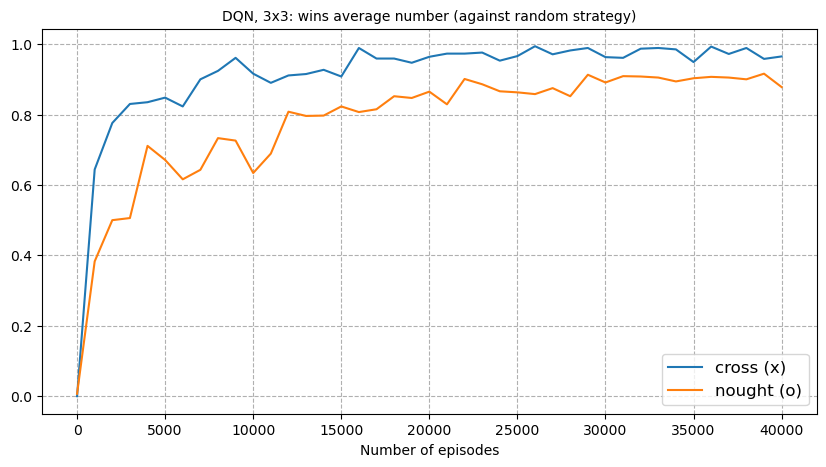

In [15]:
plot_result(
    episode, win_rate_cross, win_rate_nought, 
    title=f"DQN, {env.n_rows}x{env.n_cols}: wins average number (against random strategy)"
)

## b) Доска 3х3, Dueling DQN

In [39]:
N_ROWS = 3
N_COLS = 3
N_WIN = 3

EPS = 0.3
GAMMA = 1
ALPHA = 1e-3

TRANSITIONS = 40001
INITIAL_STEPS = 1024
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 256
STEPS_PER_UPDATE = 4
STEPS_PER_TARGET_UPDATE = STEPS_PER_UPDATE * 1000

np.random.seed(123)

In [40]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)

dqn_cross = DQN(env=env, qnetwork=DuelingQNetwork3, hidden_size=256, action_size=N_ROWS*N_COLS)
dqn_nought = DQN(env=env, qnetwork=DuelingQNetwork3, hidden_size=256, action_size=N_ROWS*N_COLS)
agent_rand = RandomAgent(env, None, None)

In [41]:
buffer_replay_init(env, dqn_cross, dqn_nought)

mean_reward_cross, mean_reward_nought, win_rate_cross, win_rate_nought, episode = [], [], [], [], []

print("Training...")
pbar = tqdm(range(TRANSITIONS))

for i in pbar:
    
    _ = step(env, dqn_cross, dqn_nought, eps=EPS)
    
    if i % 1000 == 0:
        r_cross, _, w_cross, _ = evaluate_policy(
            env=env, agent1=dqn_cross, agent2=agent_rand, n_games=1000
        )
        _, r_nought, _, w_nought = evaluate_policy(
            env=env, agent1=agent_rand, agent2=dqn_nought, n_games=1000
        )
        episode.append(i)
        mean_reward_cross.append(r_cross)
        mean_reward_nought.append(r_nought)
        win_rate_cross.append(w_cross)
        win_rate_nought.append(w_nought)
            
        pbar.set_description("%f, %f" % (w_cross, w_nought))
        

Buffer Replay Init...


100%|█████████████████████████████████████| 1024/1024 [00:00<00:00, 2059.37it/s]


Training...


0.961000, 0.850000: 100%|█████████████████| 40001/40001 [14:43<00:00, 45.28it/s]


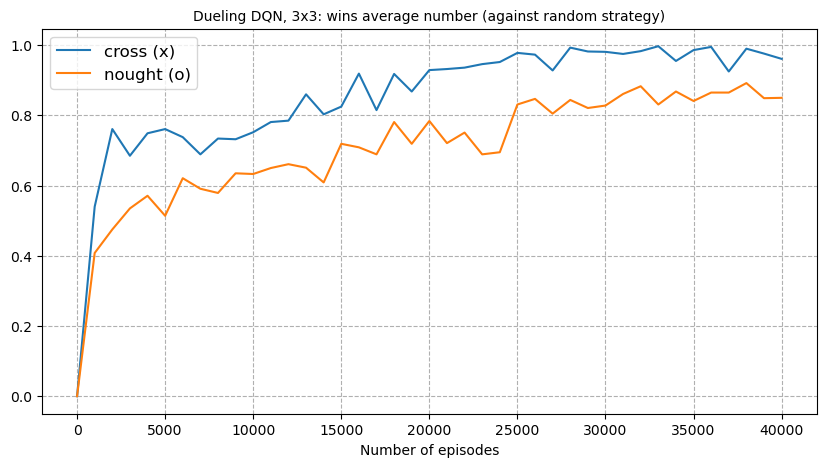

In [42]:
plot_result(
    episode, win_rate_cross, win_rate_nought, 
    title=f"Dueling DQN, {env.n_rows}x{env.n_cols}: wins average number (against random strategy)"
)

## c) Доска 4х4, Dueling DQN

In [66]:
N_ROWS = 4
N_COLS = 4
N_WIN = 4

EPS = 0.3
GAMMA = 1
ALPHA = 3e-4

TRANSITIONS = 60001
INITIAL_STEPS = 1024
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 256
STEPS_PER_UPDATE = 4
STEPS_PER_TARGET_UPDATE = STEPS_PER_UPDATE * 1500

np.random.seed(123)

In [67]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)

dqn_cross = DQN(env=env, qnetwork=DuelingQNetwork4, hidden_size=64, action_size=N_ROWS*N_COLS)
dqn_nought = DQN(env=env, qnetwork=DuelingQNetwork4, hidden_size=64, action_size=N_ROWS*N_COLS)
agent_rand = RandomAgent(env, None, None)

In [68]:
buffer_replay_init(env, dqn_cross, dqn_nought)

mean_reward_cross, mean_reward_nought, win_rate_cross, win_rate_nought, episode = [], [], [], [], []

print("Training...")
pbar = tqdm(range(TRANSITIONS))

for i in pbar:
    
    _ = step(env, dqn_cross, dqn_nought, eps=EPS)
    
    if i % 1500 == 0:
        r_cross, _, w_cross, _ = evaluate_policy(
            env=env, agent1=dqn_cross, agent2=agent_rand, n_games=1000
        )
        _, r_nought, _, w_nought = evaluate_policy(
            env=env, agent1=agent_rand, agent2=dqn_nought, n_games=1000
        )
        episode.append(i)
        mean_reward_cross.append(r_cross)
        mean_reward_nought.append(r_nought)
        win_rate_cross.append(w_cross)
        win_rate_nought.append(w_nought)
            
        pbar.set_description("%f, %f" % (w_cross, w_nought))
        

Buffer Replay Init...


100%|██████████████████████████████████████| 1024/1024 [00:01<00:00, 930.62it/s]


Training...


0.733000, 0.601000: 100%|█████████████████| 60001/60001 [47:05<00:00, 21.23it/s]


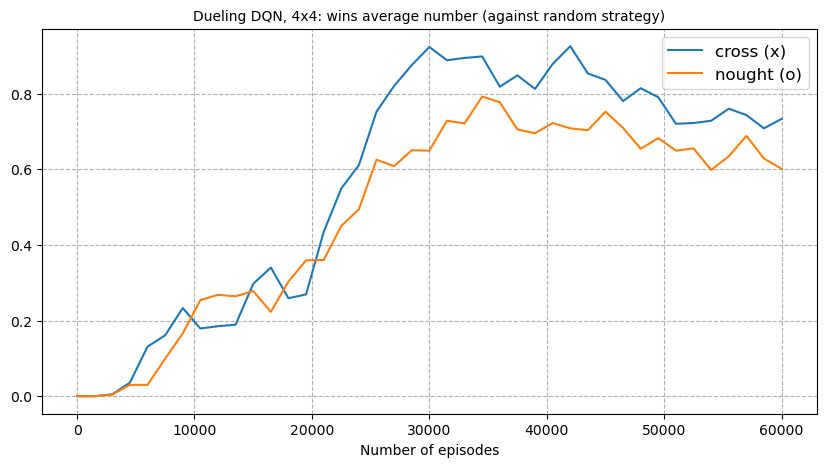

In [69]:
plot_result(
    episode, win_rate_cross, win_rate_nought, 
    title=f"Dueling DQN, {env.n_rows}x{env.n_cols}: wins average number (against random strategy)"
)

## Выводы по второй части

* Были реализованы *DQN* и *Dueling DQN*.

* Для доски **3х3** снова все хорошо получилось. В обоих случаях для крестиков средний выигрыш против случайной стратегии составил порядка $0,98$, для ноликов - порядка $0,89$.

* Для доски **4х4** использовался только *Dueling DQN*. Результаты получились лучше, чем при *Qlearning*. Для крестиков максимальный средний выигрыш против случайной стратегии составил порядка $0,9$, для ноликов - порядка $0,8$.

# Часть третья: расширим и углубим поиск
Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.
* Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).
* Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.


In [35]:
class Node:
    def __init__(self, parent=None, state=None, turn=None, actions=None):
        """Узел дерева."""
        self.state = state
        self.turn = turn
        self.parent = parent
        self.children = []
        self.actions = actions
        self.is_terminated = False
        self.visits = 0
        self.wins = 0
        self.draws = 0
        self.losses = 0
        self._c = np.sqrt(2.)
        
    def value_(self):
        if self.visits == 0:
            return 0
        # success_percentage = (self.wins + self.draws) / self.visits
        success_percentage = self.wins / self.visits
        return success_percentage

    def value(self):
        """Value-state."""
        if self.visits == 0:
            return np.inf
        success_percentage = self.value_()
        # success_percentage = self.wins / self.visits
        exploration_term = np.sqrt(np.log(self.parent.visits) / self.visits)
        return success_percentage + self._c * exploration_term
    

In [36]:
class MCTS:
    """Monte-Carlo Tree Search."""

    def __init__(self, env):
        self.env = env
        self.root = None

    def add_children_to_node(self, node):
        """Добавление потомков к узлу."""
        state, possible_actions, player = self.env.getState()
        node.actions = possible_actions
        node.state = state
        for _ in possible_actions:
            node.children.append(
                Node(parent=node, turn=-player)
            )

    def selection(self, node):
        """Фаза selection."""
        while node.visits != 0:
            values = [child.value() for child in node.children]
            optimal_child_idx = np.argmax(values)
            action = node.actions[optimal_child_idx]
            _, _, terminated, _ = self.env.step(action)
            node = node.children[optimal_child_idx]
            if terminated:
                node.is_terminated = True
                break
        return node

    def expansion(self, node):
        """Фаза expansion."""
        if node.is_terminated:
            return node
        if not node.children:
            self.add_children_to_node(node)
        # выбираем первый узел
        next_node_number = 0
        (state, possible_actions, _), reward, terminated, _ = self.env.step(node.actions[next_node_number])
        node = node.children[next_node_number]
        node.state = state
        if terminated:
            node.is_terminated = True
        return node

    def rollout(self, node):
        """Фаза rollout."""
        _, possible_actions, player = self.env.getState()
        if node.is_terminated:
            reward = -player
            return reward
        terminated = False
        while not terminated:
            action = possible_actions[np.random.choice(possible_actions.shape[0])]
            (_, possible_actions, _), reward, terminated, _ = self.env.step(action)
        return reward

    def backpropagation(self, node, reward):
        """Обратное прокидывание."""
        while True:
            if self._is_win(reward, node.turn):
                node.wins += 1
            elif self._is_draw(reward, node.turn):
                node.draws += 1
            else:
                node.losses += 1
            node.visits += 1
            if node.parent is None:
                break
            node = node.parent

    def step(self):
        """Один шаг MCTS."""
        self.env.reset()
        node = self.root
        node_s = self.selection(node)
        node_e = self.expansion(node_s)
        reward = self.rollout(node_e)
        self.backpropagation(node_s, reward)

    def train(self, n_steps, val_step):
        """Тренировка."""
        win_rate_cross, win_rate_nought, episode = [], [], []

        self.env.reset()
        state, possible_actions, turn = self.env.getState()
        self.root = Node(state=state, turn=turn)

        pbar = tqdm(range(n_steps))

        for i in pbar:
            self.step()
            if i % val_step == 0:
                w_cross = self.evaluate(player=1, n_steps=1000)
                w_nought = self.evaluate(player=-1, n_steps=1000)
                episode.append(i)
                win_rate_cross.append(w_cross)
                win_rate_nought.append(w_nought)
                pbar.set_description("%f, %f" % (w_cross, w_nought))

        return episode, win_rate_cross, win_rate_nought

    def evaluate(self, player, n_steps):
        # Проверка стратегии.
        win_count = 0
        for _ in range(n_steps):
            self.env.reset()
            terminated = False
            node = self.root
            while not terminated:
                if node.turn == player and node.children:
                    values = [child.value_() for child in node.children]
                    optimal_child_idx = np.argmax(values)
                    _, reward, terminated, _ = self.env.step(node.actions[optimal_child_idx])
                    node = node.children[optimal_child_idx]
                else:
                    if not node.children:
                        self.add_children_to_node(node)
                    _, possible_actions, _ = self.env.getState()
                    rand_child_idx = np.random.choice(len(possible_actions))
                    action = possible_actions[rand_child_idx]
                    _, reward, terminated, _ = self.env.step(action)
                    node = node.children[rand_child_idx]
            if reward == player:
                win_count += 1
        return win_count / n_steps

    def _is_win(self, reward, turn):
        """Определяем: выигрыш ли был для текущего игрока был."""
        if reward != 0 and reward * turn < 0:
            return True
        return False

    def _is_draw(self, reward, turn):
        """Определяем: ничья ли была для текущего игрока был."""
        if reward == 0:
            return True
        return False
    

## a) Доска 3х3, MCTS

In [438]:
N_ROWS = 3
N_COLS = 3
N_WIN = 3

np.random.seed(123)

In [439]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)

mcts = MCTS(env=env)

episode, win_rate_cross, win_rate_nought = mcts.train(n_steps=120_001, val_step=2000)

0.962000, 0.779000: 100%|█████████████| 120001/120001 [01:30<00:00, 1321.07it/s]


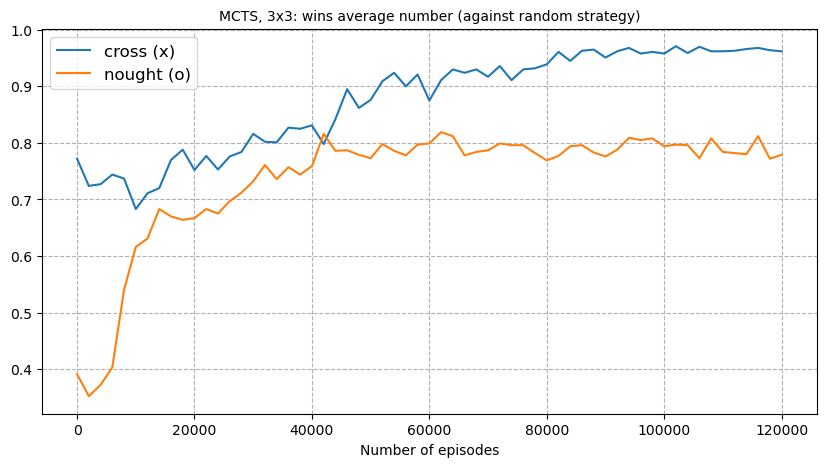

In [441]:
plot_result(
    episode, win_rate_cross, win_rate_nought, 
    title=f"MCTS, {env.n_rows}x{env.n_cols}: wins average number (against random strategy)"
)

## b)  Доска 4х4, MCTS

In [32]:
N_ROWS = 4
N_COLS = 4
N_WIN = 4

np.random.seed(123)

In [33]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)

mcts = MCTS(env=env)

episode, win_rate_cross, win_rate_nought = mcts.train(n_steps=400_001, val_step=10_000)

0.593000, 0.385000: 100%|██████████████| 400001/400001 [09:22<00:00, 711.40it/s]


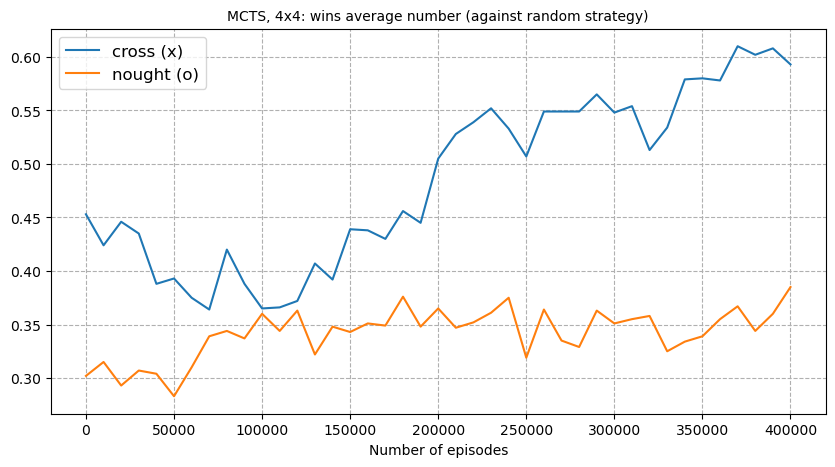

In [34]:
plot_result(
    episode, win_rate_cross, win_rate_nought, 
    title=f"MCTS, {env.n_rows}x{env.n_cols}: wins average number (against random strategy)"
)

## Выводы по третьей части:

* Для доски **3х3** получились результаты чуть-чуть похуже, чем в предыдущих пунктах. Средний процент выигрышей для крестиков составил порядка $0,97$, а для ноликов - $0,8$. При этом, результат для ноликов, в моем случае, оказался чувствительным к значению константы для *UCB1*. При стандартном значении $\sqrt{2}$ средний процент количества выигрышей для ноликов сходился к $0,5$. Пришлось увеличить до $\sqrt{20}$, чтобы результат стал лучше.
* Для доски **4х4** не удалось добиться каких-то внушительных результатов. На $400.000$ разыгранных эпизодов результат для крестиков сопоставим с результатами, полученными при **Qlearning** на том же количестве игр. Но для ноликов хуже получилось. Видимо, здесь также надо подбирать константу для *UCB1*. Не успел этого сделать.
